<a href="https://colab.research.google.com/github/btroib/Final_DS_Project/blob/master/Final_project_after_CNN_MBmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Intro

** Team Number One ** 

In [2]:
!git clone https://github.com/btroib/Final_DS_Project.git

Cloning into 'Final_DS_Project'...
remote: Enumerating objects: 5621, done.
remote: Counting objects: 100% (5621/5621), done.
remote: Compressing objects: 100% (5294/5294), done.
remote: Total 5621 (delta 341), reused 5596 (delta 325), pack-reused 0
Receiving objects: 100% (5621/5621), 89.27 MiB | 24.32 MiB/s, done.
Resolving deltas: 100% (341/341), done.


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Work split: 
- Brian Troib: git set up + data discovery and set up+ first notebook + work on the EDA
- Dan Oren: approach + work on modeling (model running).
- Michael Ben Mergui: work on modeling + report modeling + report Next steps.
- Roy Fassler: work on EDA plots + EDA report.

# 1. EDA

In [4]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from matplotlib.pyplot import imread

In [5]:
def check_missing(dataframe):
    if len(dataframe.columns[dataframe.isnull().any()]) == 0:
        print('There are no missing values.')
    else:
        print('Column Name', ' ', 'Number of Missing Values', ' ', 'Percentage of Total')
        for index, value in dataframe.isnull().sum().items():
            if value>0:
                print(index, ' '*(23-len(index)), value, ' '*(18-len(str(value))),'  ', 
                      round(value*100/len(dataframe), 2), "%")
                
def check_eda(dataframe):
    print('Preview of data: ')
    display(dataframe.head(3))
    print('\n', '-'*50, '\n')
    find_shape(dataframe)
    print('\n', '-'*50)
    print('\n Total number of rows, column types and null values:\n')
    print(dataframe.info())
    
def find_shape(dataframe):
    print('Rows:', dataframe.shape[0])
    print('Columns:', dataframe.shape[1])
    
def check_integrity(dataframe):
    print('Checking for duplicated rows...')
    print('\nNumber of duplicated rows: ', dataframe[dataframe.duplicated()].shape[0])
    if (dataframe[dataframe.duplicated()].shape[0]) > 0:
        print('\nDropping duplicates...')
        dataframe.drop_duplicates(inplace=True)
        print('\nDropped.')
    print('\nChecking min, max, mean and STD of numerical features to see if any values are illogical.')
    display(dataframe.describe(include='all').transpose())
    print('\nCounting the unique values of non numerical features (including missing values):\n')
    for col in dataframe.select_dtypes(include='object').columns:
        print('Count of: ', col)
        print(dataframe[col].value_counts(dropna=False), '\n')

#### We will start with reading the files hemorrhage_diagnosis.csv and patient_demographics.csv. The first file contains the labels (hemorrhage type, fracture) for each slice and for each patient and the second file contains information related to the patient such as patient age and gender.

In [6]:
df_hemorrhage = pd.read_csv('Final_DS_Project/hemorrhage_diagnosis.csv')
df_patient = pd.read_csv('Final_DS_Project/patient_demographics.csv')

We'll take a look at the header of the dataframes to check that all the names of the columns and the values are aligned.

In [7]:
df_hemorrhage.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [8]:
df_patient.head()

,Patient Number,Age\n(years),Gender,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No),Condition on file,Note
0,49,35.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN
1,50,0.583333,Female,NaN,1.0,NaN,NaN,NaN,1.0,Subdural HGE,NaN
2,51,5.000000,Male,NaN,1.0,NaN,NaN,1.0,1.0,Extadural HGE,NaN
3,52,8.000000,Male,NaN,NaN,NaN,1.0,NaN,1.0,Extadural HGE,NaN
4,53,44.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN


It is also necessary to know the dimensions of the data.

In [9]:
rows, columns = df_hemorrhage.shape
print(f"The dataset hemorrhage contains {rows} rows and {columns} columns")
rows, columns = df_patient.shape
print(f"The dataset patient contains {rows} rows and {columns} columns")

The dataset hemorrhage contains 2501 rows and 9 columns
The dataset patient contains 82 rows and 11 columns


In [10]:
assert df_patient["Patient Number"].is_unique

In [11]:
df_hemorrhage.groupby("PatientNumber").size().mean()

30.5

We can see that the data set contains the information of 82 patients and of each one we have the information of certain demographics such as age and gender. Also, in the hemorrhage diagnosis dataset we can see that on average each patient has 30.5 thomography slices. 

Next we are going to load the thomography slices.

In [12]:
IMAGES_DIRECTORY = 'Final_DS_Project/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/Patients_CT'
patient = {}
for paitent_folder in os.listdir(IMAGES_DIRECTORY):
    patient_brain_folder = IMAGES_DIRECTORY+"/"+paitent_folder+"/brain"
    for image_name in os.listdir(patient_brain_folder):
        if len(image_name[:-4]) > 2 :
          continue
        img = cv2.imread(patient_brain_folder+"/"+image_name, cv2.IMREAD_GRAYSCALE).flatten()
        patient[f'{paitent_folder}-{image_name[:-4]}'] = img



Next we are going to transform the dictionary patient to a dataframe df_brain.

In [13]:
df_brain = pd.DataFrame(patient)
df_brain = df_brain.transpose()

In [14]:
df_brain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,422460,422461,422462,422463,422464,422465,422466,422467,422468,422469,422470,422471,422472,422473,422474,422475,422476,422477,422478,422479,422480,422481,422482,422483,422484,422485,422486,422487,422488,422489,422490,422491,422492,422493,422494,422495,422496,422497,422498,422499
077-7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
077-9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
077-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
077-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
077-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df_brain.shape

(2501, 422500)

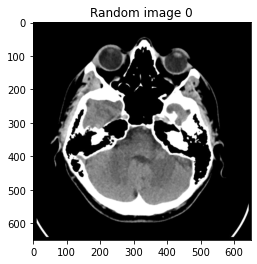

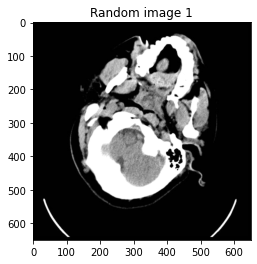

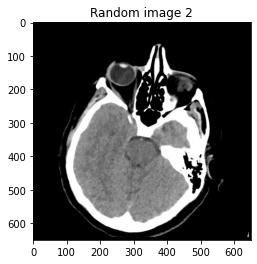

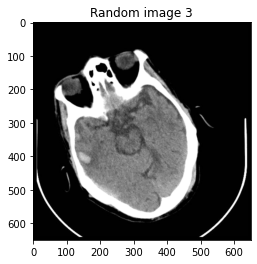

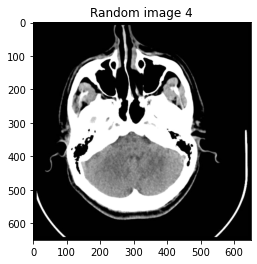

In [16]:
for index in range(5):
  random_image = df_brain.sample().to_numpy().reshape(650,-1)
  plt.title(f'Random image {index}')
  plt.imshow(random_image, cmap='gray');
  plt.show();

We can see that the index of our dataframe represents the indetifier of the patient and image and the columns represent each pixel of the image. The size of the images is 650x650 pixels, so it makes sense that we have 422,500 columns

$ 650^2 = 422500 $

#### General summary statistics

Let's start by analyzing df_patient

In [17]:
df_patient.describe()

,Patient Number,Age\n(years),Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No)
count,82.000000,82.000000,5.0,16.0,7.0,21.0,4.0,22.0
mean,89.500000,27.843733,1.0,1.0,1.0,1.0,1.0,1.0
std,23.815261,19.520890,0.0,0.0,0.0,0.0,0.0,0.0
min,49.000000,0.002747,1.0,1.0,1.0,1.0,1.0,1.0
25%,69.250000,11.250000,1.0,1.0,1.0,1.0,1.0,1.0
50%,89.500000,26.000000,1.0,1.0,1.0,1.0,1.0,1.0
75%,109.750000,40.000000,1.0,1.0,1.0,1.0,1.0,1.0
max,130.000000,72.000000,1.0,1.0,1.0,1.0,1.0,1.0


In [18]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient Number     82 non-null     int64  
 1   Age
(years)        82 non-null     float64
 2   Gender             82 non-null     object 
 3   Intraventricular   5 non-null      float64
 4   Intraparenchymal   16 non-null     float64
 5   Subarachnoid       7 non-null      float64
 6   Epidural           21 non-null     float64
 7   Subdural           4 non-null      float64
 8   Fracture (Yes/No)  22 non-null     float64
 9   Condition on file  82 non-null     object 
 10  Note               1 non-null      object 
dtypes: float64(7), int64(1), object(3)
memory usage: 7.2+ KB


In [19]:
df_patient.describe(include=['O'])

,Gender,Condition on file,Note
count,82,82,1
unique,2,13,1
top,Male,Normal CT,"Special case, CT scan was after about two week..."
freq,46,47,1


Observations:

* The average age of the sample is 28 years, and covers a range from 0 to 72 years.
* The gender of the sample is balanced: 46 Male and 36 Female.
* 57% of the sample has a Normal CT.

We can see that when the patient does not present any condition of: Intraventricular, Intraparenchymal, Subarachnoid, Epidural, Subdural or Fracture (Yes / No), it is marked as Nan. A good option is to fillna these columns with the value 0. Also, only one patient has a comment in the Note column.

Let's continue with the dataframe df_hemorrhage

In [20]:
df_hemorrhage.describe()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
count,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000
mean,89.591363,15.909636,0.009596,0.029188,0.007197,0.069172,0.022391,0.872851,0.077969
std,23.762360,9.071176,0.097508,0.168368,0.084547,0.253798,0.147981,0.333207,0.268176
min,49.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,90.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,110.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,130.000000,40.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
df_hemorrhage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   PatientNumber     2501 non-null   int64
 1   SliceNumber       2501 non-null   int64
 2   Intraventricular  2501 non-null   int64
 3   Intraparenchymal  2501 non-null   int64
 4   Subarachnoid      2501 non-null   int64
 5   Epidural          2501 non-null   int64
 6   Subdural          2501 non-null   int64
 7   No_Hemorrhage     2501 non-null   int64
 8   Fracture_Yes_No   2501 non-null   int64
dtypes: int64(9)
memory usage: 176.0 KB


Observations:

* 87% of patients are No_Hemorrhage.
* The most common hemorrhage is Epidural (6%), followed by Intraparenchymal (2.9%).

We can see that in this dataset it has no missing values.

As we saw previously, the df_patient dataframe has several columns with missing values, below we can observe the% of null values in each one.

In [22]:
check_missing(df_patient)

Column Name   Number of Missing Values   Percentage of Total
Intraventricular         77                     93.9 %
Intraparenchymal         66                     80.49 %
Subarachnoid             75                     91.46 %
Epidural                 61                     74.39 %
Subdural                 78                     95.12 %
Fracture (Yes/No)        60                     73.17 %
Note                     81                     98.78 %


#### Some interesting plots

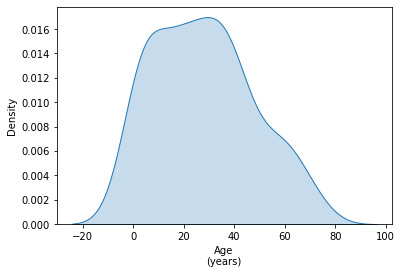

In [23]:
sns.kdeplot(data=df_patient, x="Age\n(years)", shade=True);

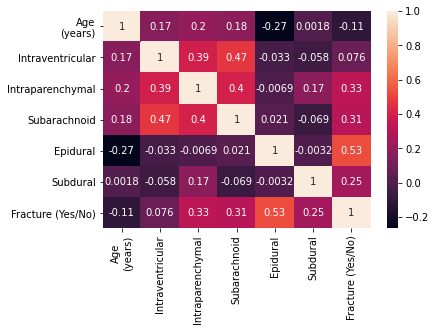

In [24]:
sns.heatmap(df_patient.drop("Patient Number",axis=1).fillna(0).corr(), annot=True);

# 2. Model baseline building

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, \
                            precision_score, classification_report, f1_score
from sklearn.model_selection import train_test_split

## Splitting the Hemorrage_diagnosic dataset

We have decided to first focus on predicting, based on our Hemorrage dataset, if the patients have (or not) a brain hemorrhage.  
This is a **Classification** problem we are adressing.

- Target (to predict): 'No_Hemorrhage'.
- Features: our brain CT scans from all patients.  

We will start by splitting the dataset in a Train (80%). and test sets (20%).

In [26]:
X = df_brain
y = df_hemorrhage['No_Hemorrhage']

#Data Augmentaion

In [27]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [28]:
# creating folders
!mkdir train
!mkdir train/0 train/1
!mkdir test
!mkdir test/0 test/1

In [29]:
#Saving images in 2 folders according to type for data augmentation
for index in range(y.shape[0]):
  if y[index] == 0:
    new_img = X.iloc[index].to_numpy().reshape(650,-1)
    cv2.imwrite(f"train/{y[index]}/{index}.jpg", new_img)
  else:
    new_img = X.iloc[index].to_numpy().reshape(650,-1)
    cv2.imwrite(f"train/{y[index]}/{index}.jpg", new_img)
    

In [30]:
train_path_0 = r'train/0'
train_path_1 = r'train/1'
test_path_0 = r'test/0'
test_path_1 = r'test/1'

In [31]:
print(f"Class 0 before aug: {len(os.listdir(train_path_0))}")
print(f"Class 1 before aug: {len(os.listdir(train_path_1))}")
CLASS_0_SIZE = 318
CLASS_1_SIZE = 2183

Class 0 before aug: 318
Class 1 before aug: 2183


In [32]:
def image_aug(dir_aug_path, number_of_aug):
  datagen = ImageDataGenerator(rotation_range=90)
  for f in os.listdir(dir_aug_path):
    img = load_img(dir_aug_path + '/' + f)  
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0

    # generate new augmented images 
    for batch in datagen.flow(x, batch_size = 1, 
                              save_to_dir = dir_aug_path,  
                              save_prefix ='aug', save_format ='jpg'):
        i += 1
        if i > number_of_aug-1: 
            break

In [33]:
import random
size_of_test_0 = round(len(os.listdir(train_path_0))*0.2)
size_of_train_0 = len(os.listdir(train_path_0)) - size_of_test_0
test_list_0 = random.sample(os.listdir(train_path_0),size_of_test_0)
size_of_test_1 = round(len(os.listdir(train_path_1))*0.2)
size_of_train_1 = len(os.listdir(train_path_1)) - size_of_test_1
test_list_1 = random.sample(os.listdir(train_path_1),size_of_test_1)
for file_name in test_list_0:
  os.rename('train/0/' + file_name, 'test/0/' + file_name)
for file_name in test_list_1:
  os.rename('train/1/' + file_name, 'test/1/' + file_name)

In [34]:
if len(os.listdir(train_path_0)) == size_of_train_0:
  image_aug(train_path_0,20)
if len(os.listdir(test_path_0)) == size_of_test_0:
  image_aug(test_path_0,20)
if len(os.listdir(train_path_1)) == size_of_train_1:
  image_aug(train_path_1,2)
if len(os.listdir(test_path_1)) == size_of_test_1:
  image_aug(test_path_1,2)

print(f"Train 0 after aug: {len(os.listdir(train_path_0))}")
print(f"Train 1 after aug: {len(os.listdir(train_path_1))}")
print(f"Test 0 after aug: {len(os.listdir(test_path_0))}")
print(f"Test 1 after aug: {len(os.listdir(test_path_1))}")

Train 0 after aug: 4233
Train 1 after aug: 4660
Test 0 after aug: 1269
Test 1 after aug: 1272


#After Data Augmentation of images

In [35]:
print(f'Model Baseline :{y.sum() / len(y)}')

Model Baseline :0.8728508596561375


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=42,
                                                   test_size=0.2)

print(f"Train set: {len(X_train)/len(X):.2%}")
print(f"Train set: {len(X_test)/len(X):.2%}")

Train set: 79.97%
Train set: 20.03%


We will first apply a simple classification model: **Logistic Regression**.

We chose this model because it is known to work well for binary classification problems, and we will use it as our baseline.  
We will later on also be able to tweak its hyperparameter, i.e. the threshold, to improve its performance.

In [37]:
# from sklearn.linear_model import LogisticRegression

In [38]:
# clf = LogisticRegression(solver='lbfgs', max_iter=1000)
# clf.fit(X_train, y_train)

In [39]:
# y_pred = clf.predict(X_test)

In [40]:
# print(classification_report(y_test,y_pred))

# SGD

In [41]:
from sklearn.linear_model import SGDClassifier

In [42]:
sgdc = SGDClassifier(max_iter=1000, tol=0.01)
sgdc.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.01,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
score = sgdc.score(X_train, y_train)
print("Training score: ", score)

Training score:  0.9945


In [44]:
y_pred_SGD = sgdc.predict(X_test)
print(classification_report(y_test, y_pred_SGD))

              precision    recall  f1-score   support

           0       0.40      0.29      0.34        62
           1       0.90      0.94      0.92       439

    accuracy                           0.86       501
   macro avg       0.65      0.61      0.63       501
weighted avg       0.84      0.86      0.85       501



# CNN

In [45]:
img_gen = ImageDataGenerator(validation_split=0.2)

In [46]:
train_data = img_gen.flow_from_directory('train/', 
                                         class_mode= 'binary', 
                                         batch_size= 64, 
                                         target_size=(224, 224), 
                                         subset= 'training',
                                         color_mode= 'grayscale')

Found 7115 images belonging to 2 classes.


In [47]:
valid_data = img_gen.flow_from_directory('train/', 
                                         class_mode= 'binary', 
                                         batch_size= 64, 
                                         target_size=(224, 224), 
                                         subset= 'validation',
                                         color_mode= 'grayscale')

Found 1778 images belonging to 2 classes.


In [48]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
inp = Rescaling(1/255, input_shape=(224,224,1))
conv_layer = Conv2D(64, 3, activation='relu')
conv_layer2 = Conv2D(64, 3, activation='relu')
conv_layer3 = Conv2D(64, 3, activation='relu')
pool_layer = MaxPool2D()
pool_layer2 = MaxPool2D()
pool_layer3 = MaxPool2D()
flat_layer = Flatten()
dense_layer = Dense(64, activation='relu')
last_layer = Dense(1, activation='sigmoid')
model = Sequential([inp, conv_layer, pool_layer, conv_layer2, pool_layer2, 
                    conv_layer3, pool_layer3, flat_layer, last_layer])

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [51]:
history = model.fit(train_data, epochs=200, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data), callbacks=[callback])

Epoch 1/200
112/112 [==============================] - 83s 438ms/step - loss: 0.6736 - accuracy: 0.5772 - val_loss: 0.6136 - val_accuracy: 0.6676
Epoch 2/200
112/112 [==============================] - 47s 418ms/step - loss: 0.6131 - accuracy: 0.6575 - val_loss: 0.5719 - val_accuracy: 0.7165
Epoch 3/200
112/112 [==============================] - 47s 417ms/step - loss: 0.5500 - accuracy: 0.7205 - val_loss: 0.5630 - val_accuracy: 0.7244
Epoch 4/200
112/112 [==============================] - 47s 417ms/step - loss: 0.4644 - accuracy: 0.7755 - val_loss: 0.5342 - val_accuracy: 0.7362
Epoch 5/200
112/112 [==============================] - 47s 415ms/step - loss: 0.3892 - accuracy: 0.8227 - val_loss: 0.5237 - val_accuracy: 0.7672
Epoch 6/200
112/112 [==============================] - 47s 416ms/step - loss: 0.3115 - accuracy: 0.8592 - val_loss: 0.6644 - val_accuracy: 0.7312
Epoch 7/200
112/112 [==============================] - 47s 415ms/step - loss: 0.2409 - accuracy: 0.9024 - val_loss: 0.7284 -

In [52]:
test_data = img_gen.flow_from_directory(directory=r"./test/", class_mode=None, batch_size=64, target_size=(224, 224), shuffle=False, color_mode= 'grayscale')

Found 2541 images belonging to 2 classes.


In [53]:
pred = model.predict(test_data)

First conclusions of the Logistic Regression performance: 
- We have got an accuracy of `95%`, which is above the baseline of `87%` which is very good, however we can see that the **recall** and the **percision** for class `0` are around `80%` and we should try to improve them with a better model or more preprocessing. 

This gives us a good start and makes us confident in being able to model and predict brain hemorrhage from CT scan images.

# 3. Next steps

### Comments

- At this stage we did not use bone images, which could allow us to predict another target: 
- At this stage we did not use patient demographics. which might also give us a few good features on each patient.



### Main next steps

#### A) Build a model to detect intracranial hemorrhages. (0/1)

- Deal with very high dimensionality of our dataframes (>40 000 features due to image pixelisation). Options: image resizing, dimensionality reduction methods (e.g. PCA)
- Apply other classification ML models on the Hemorrhage classification.
- Apply deeplearning (e.g. CNN) with an optimized set of hyperparameters to process the images and increase model performance.
- Join and use data from the "demographics.csv" file to feed our model.


#### B) Build a model to segment hemorrhages per type

Hemorrhages exist in different types: Intraventricular, Intraparenchymal, Subarachnoid, Epidural and Subdural.  
- Build a model to try to classify in the right category. Multi-label classification problem.

### Possible extra next steps: 

- Build an API to automate the diagnosis of intracranial hemorrhages by providing the API pictures and receiving back the classification (single or multi-label).
- Build a model to identify a brain fracture from a CT scan.